In [8]:
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import healpy as hp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy.linalg as la

In [155]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]
ds = cat['um_glm_n2560_RAL3p3'](zoom=2).to_dask().sel(time=slice('2020-03-01T00:00:00','2021-03-01T00:00:00'))[['uas','vas', 'sftlf']] #
ds_winds = ds.groupby('time.hour').mean()
ds_winds = ds_winds.assign(ws = np.sqrt(ds_winds.uas**2 + ds_winds.vas**2))

/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<Figure size 640x480 with 0 Axes>

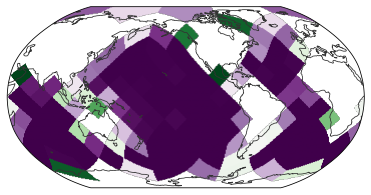

In [3]:
egh.healpix_show(ds_winds["sftlf"].sel(hour = 0), cmap = "PRGn", dpi=72)

In [156]:
def ellipse_fit(X):
        """ FROM Ben Hammel, & Nick Sullivan-Molina. (2020, March 21). 
        bdhammel/least-squares-ellipse-fitting: v2.0.0 (Version v2.0.0). 
        Zenodo. http://doi.org/10.5281/zenodo.3723294 """
        
        """Fit the data

        Parameters
        ----------
        X : array, shape (n_points, 2)
            Data values for the x-y data pairs to fit

        Returns
        -------
        self : returns an instance of self.
        """

        # extract x-y pairs
        x, y = X.T

        # Quadratic part of design matrix [eqn. 15] from (*)
        D1 = np.vstack([x**2, x*y, y**2]).T
        # Linear part of design matrix [eqn. 16] from (*)
        D2 = np.vstack([x, y, np.ones_like(x)]).T

        # Forming scatter matrix [eqn. 17] from (*)
        S1 = D1.T @ D1
        S2 = D1.T @ D2
        S3 = D2.T @ D2

        # Constraint matrix [eqn. 18]
        C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

        # Reduced scatter matrix [eqn. 29]
        M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

        # M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
        # equation [eqn. 28]
        eigval, eigvec = np.linalg.eig(M)

        # Eigenvector must meet constraint 4ac - b^2 to be valid.
        cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
        a1 = eigvec[:, np.nonzero(cond > 0)[0]]

        # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
        a2 = la.inv(-S3) @ S2.T @ a1

        # Eigenvectors |a b c d f g>
        # list of the coefficients describing an ellipse [a,b,c,d,e,f]
        # corresponding to ax**2 + bxy + cy**2 + dx + ey + f from (*)
        #self.coef_ = np.vstack([a1, a2])

        """Returns the definition of the fitted ellipse as localized parameters

        Returns
        _______
        center : tuple
            (x0, y0)
        width : float
            Total length (diameter) of horizontal axis.
        height : float
            Total length (diameter) of vertical axis.
        phi : float
            The counterclockwise angle [radians] of rotation from the x-axis to the semimajor axis
        """

        # Eigenvectors are the coefficients of an ellipse in general form
        # the division by 2 is required to account for a slight difference in
        # the equations between (*) and (**)
        # a*x^2 +   b*x*y + c*y^2 +   d*x +   e*y + f = 0  (*)  Eqn 1
        # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0  (**) Eqn 15
        # We'll use (**) to follow their documentation
        a = np.vstack([a1,a2])[0]
        b = np.vstack([a1,a2])[1] / 2.
        c = np.vstack([a1,a2])[2]
        d = np.vstack([a1,a2])[3] / 2.
        f = np.vstack([a1,a2])[4] / 2.
        g = np.vstack([a1,a2])[5]

        # Finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d - b*f) / (b**2 - a*c)
        y0 = (a*f - b*d) / (b**2 - a*c)
        center = (x0, y0)

        # Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
        denominator1 = (b**2 - a*c) * ( np.sqrt((a-c)**2+4*b**2) - (c+a))  # noqa: E201
        denominator2 = (b**2 - a*c) * (-np.sqrt((a-c)**2+4*b**2) - (c+a))
        height = np.sqrt(numerator / denominator1)
        width = np.sqrt(numerator / denominator2)

        # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
        # [eqn. 23] from (**)
        # w/ trig identity eqn 9 form (***)
        if b == 0 and a > c:
            phi = 0.0
        elif b == 0 and a < c:
            phi = np.pi/2
        elif b != 0 and a > c:
            phi = 0.5 * np.arctan(2*b/(a-c))
        elif b != 0 and a < c:
            phi = 0.5 * (np.pi + np.arctan(2*b/(a-c)))
        elif a == c:
            print("Ellipse is a perfect circle, the answer is degenerate")
            phi = 0.0
        else:
            raise RuntimeError("Unreachable")

        return center, width, height, phi

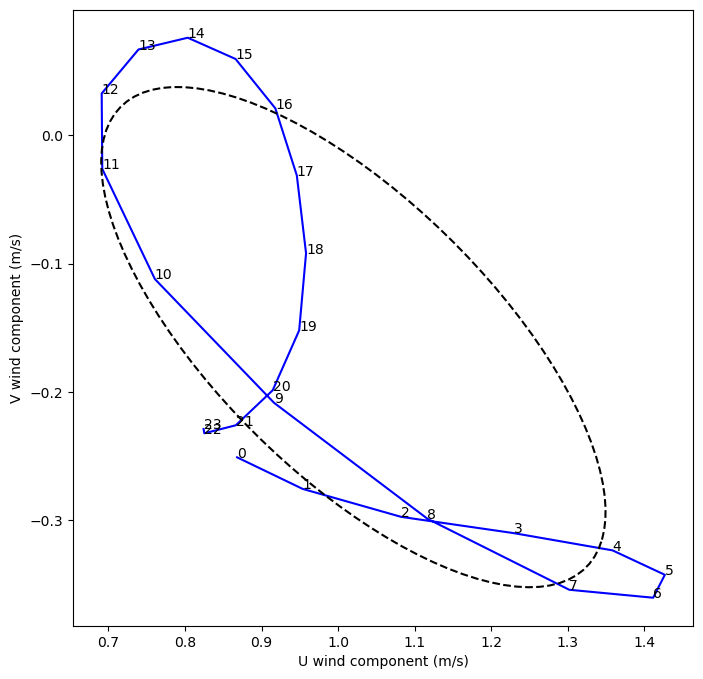

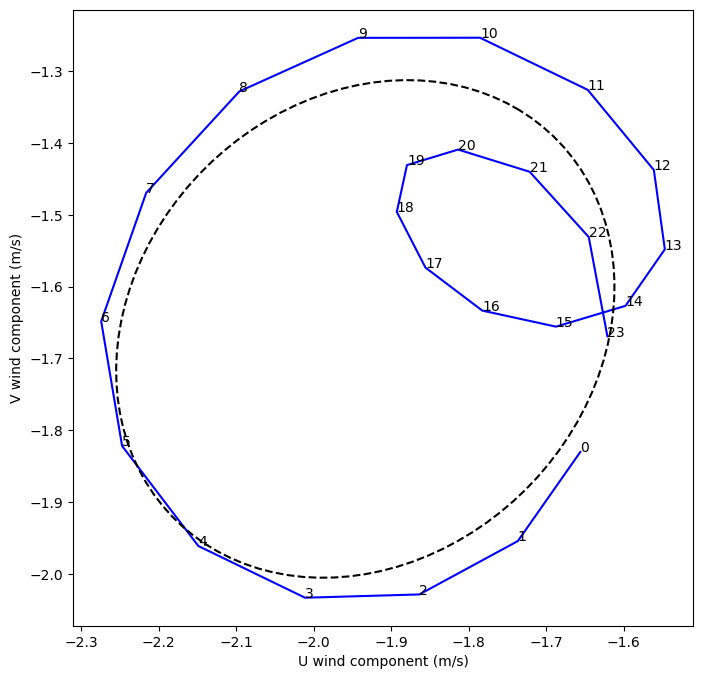

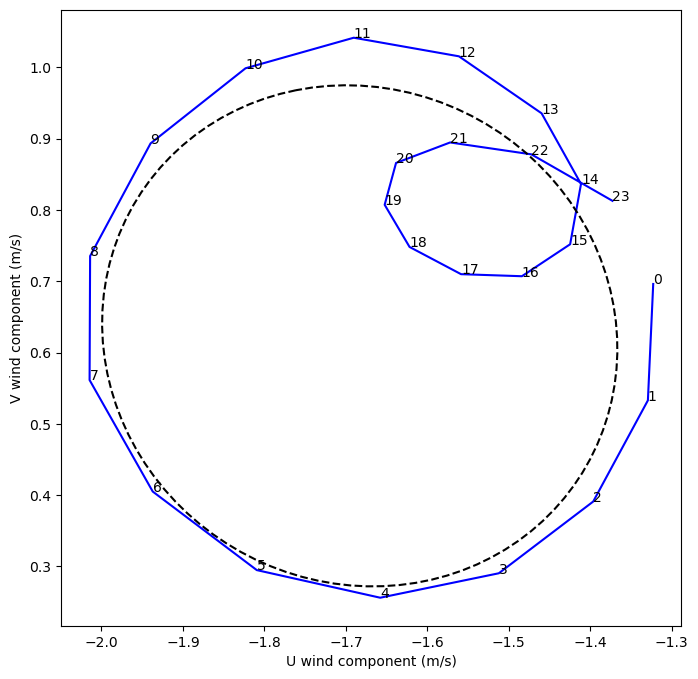

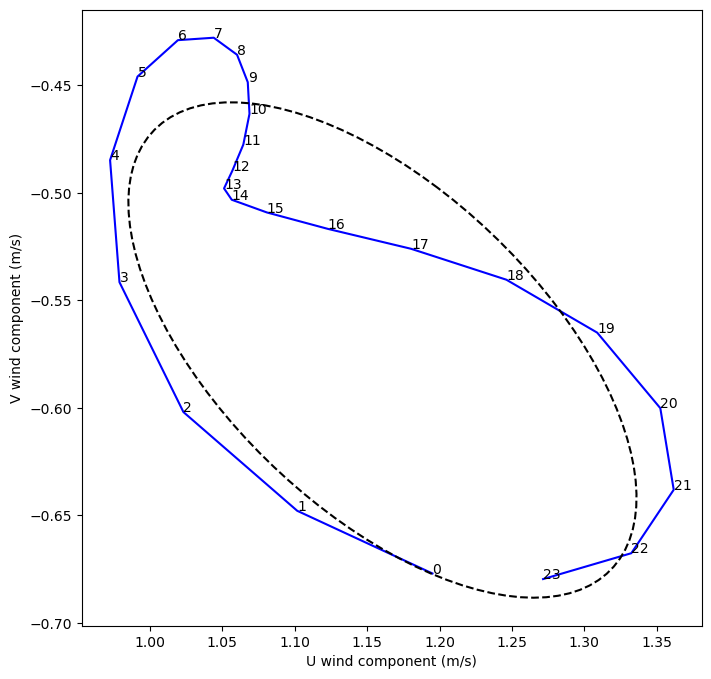

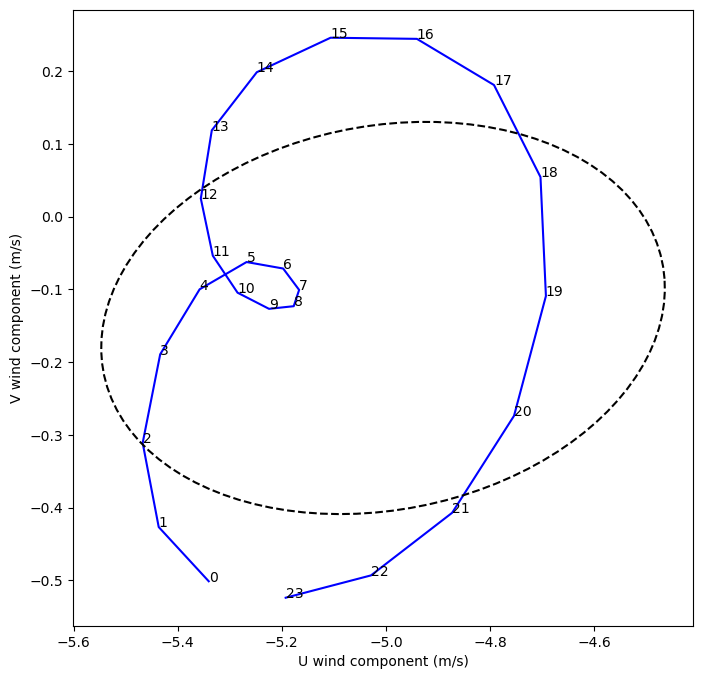

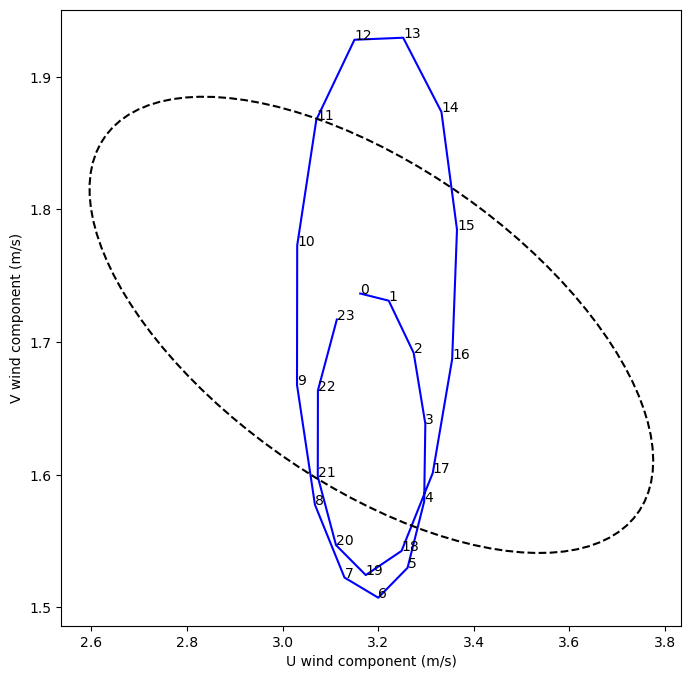

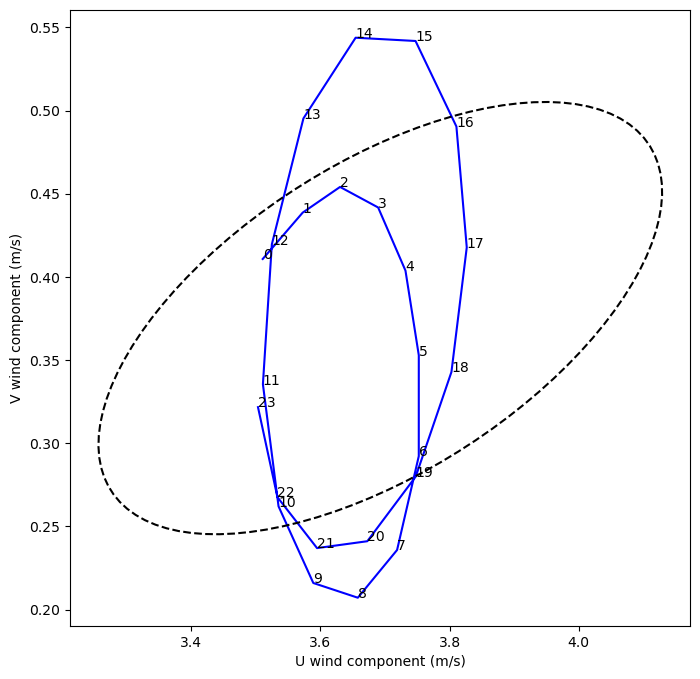

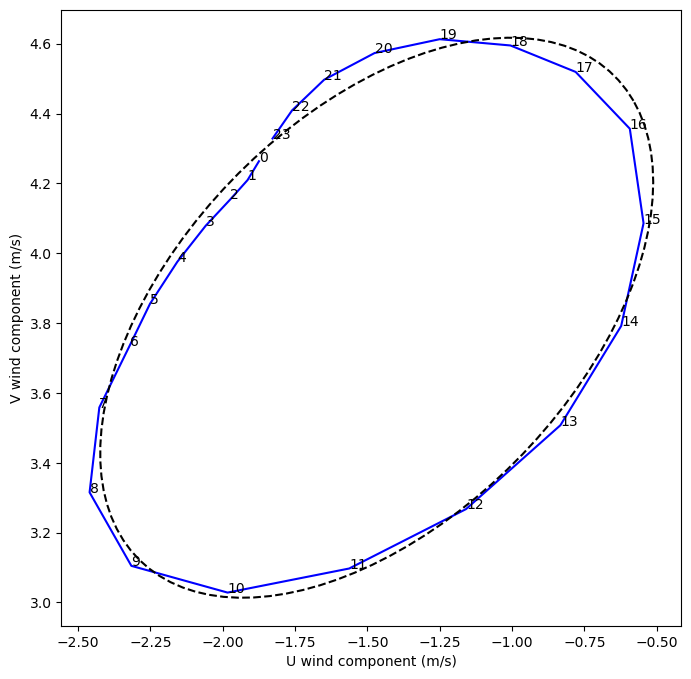

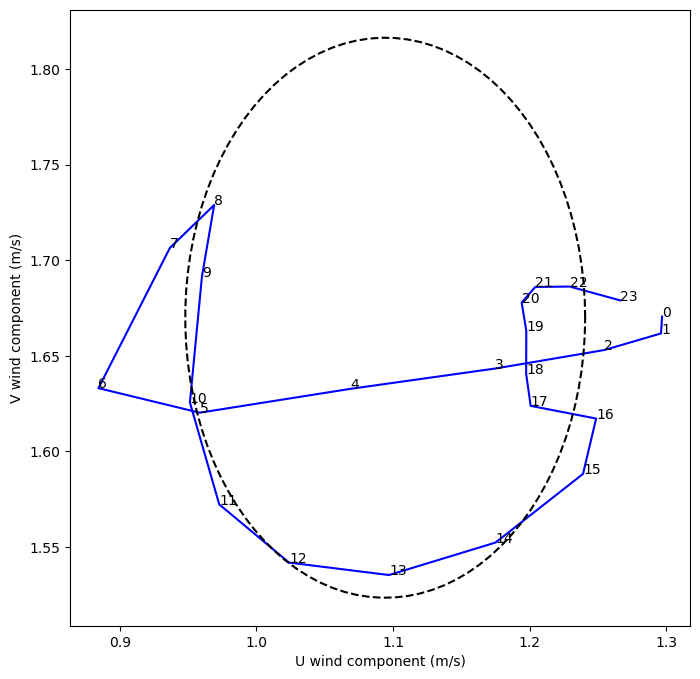

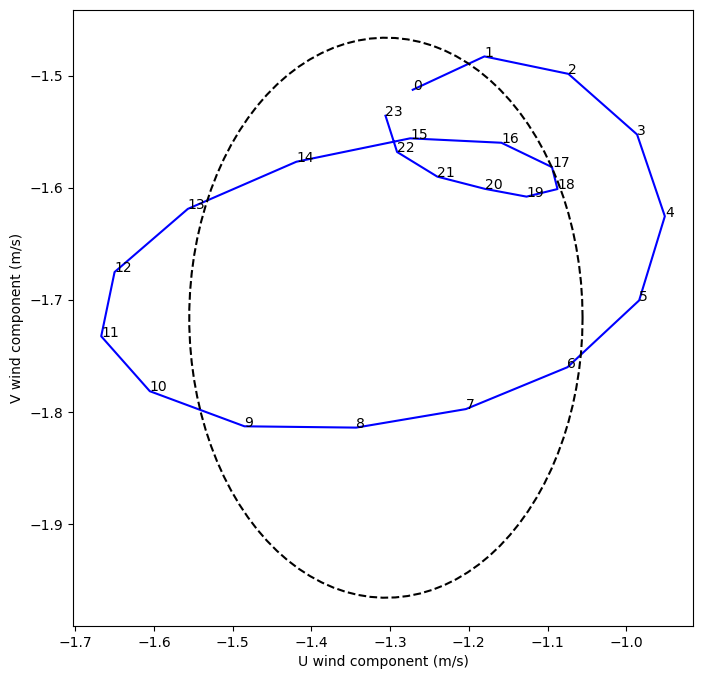

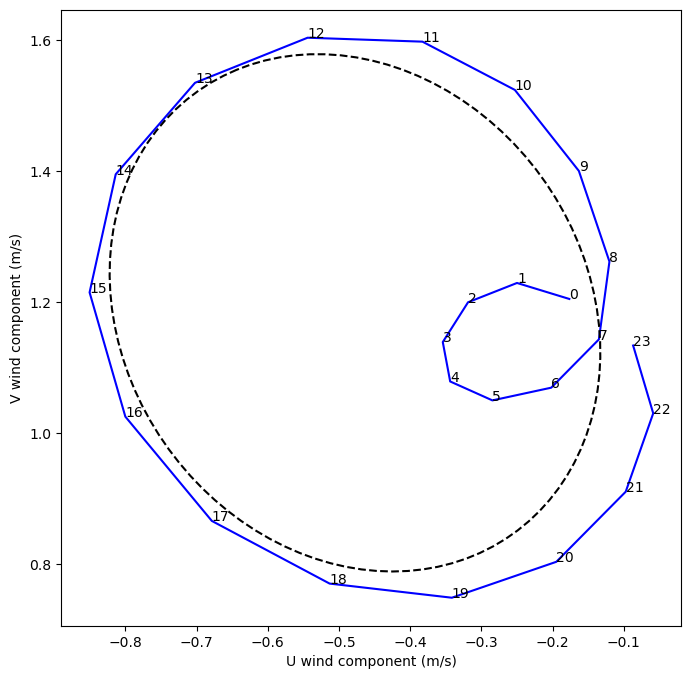

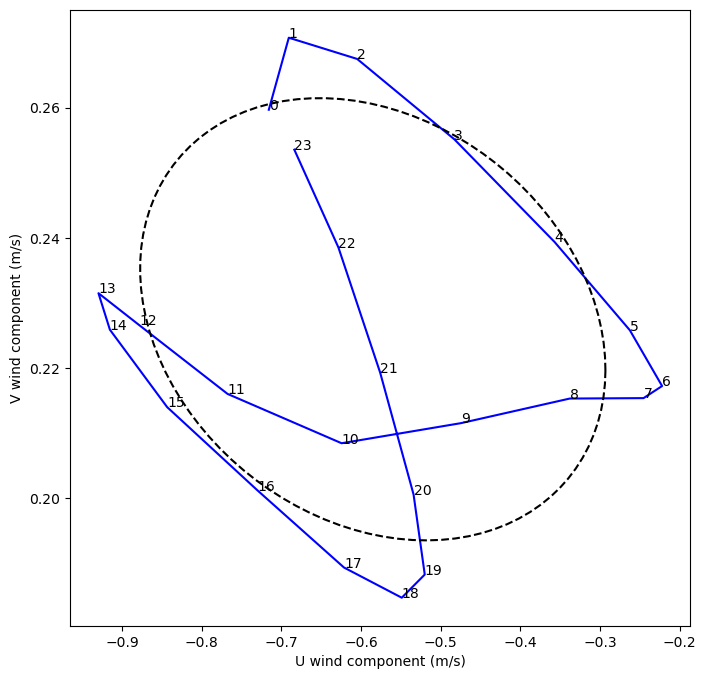

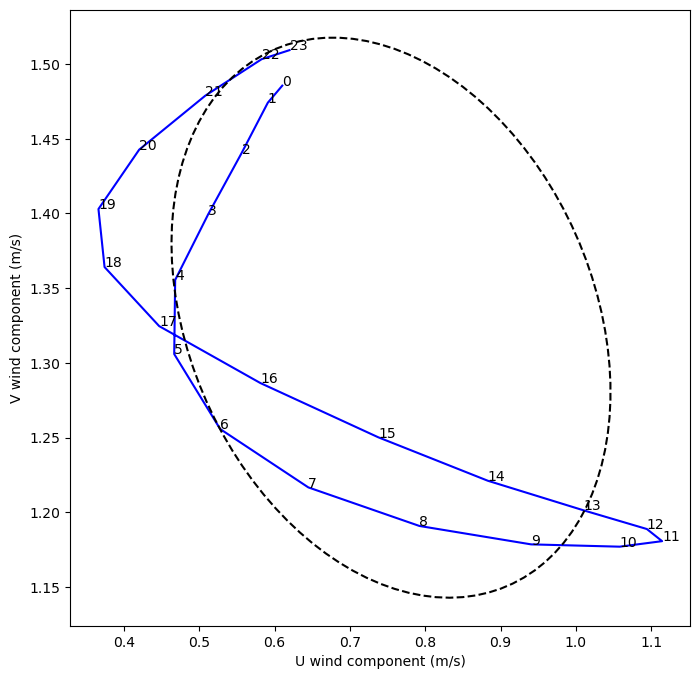

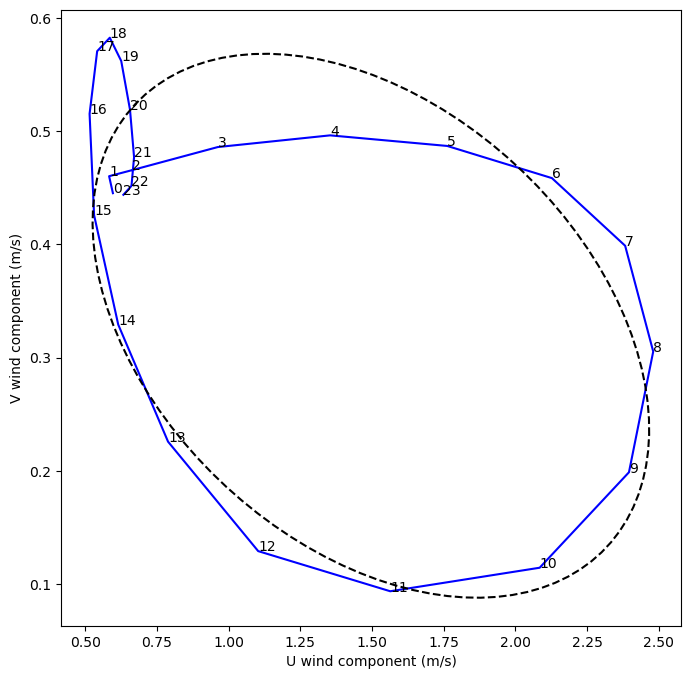

In [ ]:
for cl in range(2,100,2):
    if np.isnan(ds_winds.isel(cell=cl).uas).all() == False:
        x_ds = ds_winds.isel(cell=cl).uas.to_numpy()
        y_ds = ds_winds.isel(cell=cl).vas.to_numpy()
        try:
            points = np.array(list(zip(x_ds, y_ds)))
            center, width, height, phi = fit_oval(points)
            u0, v0 = center
            u1 = width * np.cos(phi)
            u2 = -height * np.sin(phi)
            v1 = width * np.sin(phi)
            v2 = height * np.cos(phi)
            t = np.linspace(0, 2 * np.pi, 100)
            uelip = u0 + u1 * np.cos(t) + u2 * np.sin(t)
            velip = v0 + v1 * np.cos(t) + v2 * np.sin(t)

            plt.figure(figsize=(8,8))
            plt.plot(x_ds, y_ds, c='b')
            
            plt.xlabel("U wind component (m/s)")
            plt.ylabel("V wind component (m/s)")
            plt.plot(uelip,velip, color="k", ls="--")
            for x,y,t in zip(x_ds,y_ds,range(24)):
                plt.text(x, y, t)
            #plt.savefig(f"../ellipse_plot{cl}.jpeg")
        except:
            continue

In [ ]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    Interpolate from healpix to regular lat lon
    
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )


In [26]:
#Get the "nside", which is used for regridding
nside = hp.get_nside(ds_winds.uas)

#Set up target latitude and longitude (regular grid) to interpolate onto
target_lats = np.linspace(
    -90,
    90,
    10
)
target_lons = np.linspace(
    0,
    360,
    20
)

target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

ds_latlon = ds_winds.isel(cell=target_inds)

In [ ]:
def ellipse_fit(X):
        """ FROM Ben Hammel, & Nick Sullivan-Molina. (2020, March 21). 
        bdhammel/least-squares-ellipse-fitting: v2.0.0 (Version v2.0.0). 
        Zenodo. http://doi.org/10.5281/zenodo.3723294 """
        
        """Fit the data

        Parameters
        ----------
        X : array, shape (n_points, 2)
            Data values for the x-y data pairs to fit

        Returns
        -------
        self : returns an instance of self.
        """

        # extract x-y pairs
        x, y = X.T

        # Quadratic part of design matrix [eqn. 15] from (*)
        D1 = np.vstack([x**2, x*y, y**2]).T
        # Linear part of design matrix [eqn. 16] from (*)
        D2 = np.vstack([x, y, np.ones_like(x)]).T

        # Forming scatter matrix [eqn. 17] from (*)
        S1 = D1.T @ D1
        S2 = D1.T @ D2
        S3 = D2.T @ D2

        # Constraint matrix [eqn. 18]
        C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

        # Reduced scatter matrix [eqn. 29]
        M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

        # M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
        # equation [eqn. 28]
        eigval, eigvec = np.linalg.eig(M)

        # Eigenvector must meet constraint 4ac - b^2 to be valid.
        cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
        a1 = eigvec[:, np.nonzero(cond > 0)[0]]

        # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
        a2 = la.inv(-S3) @ S2.T @ a1

        # Eigenvectors |a b c d f g>
        # list of the coefficients describing an ellipse [a,b,c,d,e,f]
        # corresponding to ax**2 + bxy + cy**2 + dx + ey + f from (*)
        #self.coef_ = np.vstack([a1, a2])

        """Returns the definition of the fitted ellipse as localized parameters

        Returns
        _______
        center : tuple
            (x0, y0)
        width : float
            Total length (diameter) of horizontal axis.
        height : float
            Total length (diameter) of vertical axis.
        phi : float
            The counterclockwise angle [radians] of rotation from the x-axis to the semimajor axis
        """

        # Eigenvectors are the coefficients of an ellipse in general form
        # the division by 2 is required to account for a slight difference in
        # the equations between (*) and (**)
        # a*x^2 +   b*x*y + c*y^2 +   d*x +   e*y + f = 0  (*)  Eqn 1
        # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0  (**) Eqn 15
        # We'll use (**) to follow their documentation
        a = np.vstack([a1,a2])[0]
        b = np.vstack([a1,a2])[1] / 2.
        c = np.vstack([a1,a2])[2]
        d = np.vstack([a1,a2])[3] / 2.
        f = np.vstack([a1,a2])[4] / 2.
        g = np.vstack([a1,a2])[5]

        # Finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d - b*f) / (b**2 - a*c)
        y0 = (a*f - b*d) / (b**2 - a*c)
        center = (x0, y0)

        # Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
        denominator1 = (b**2 - a*c) * ( np.sqrt((a-c)**2+4*b**2) - (c+a))  # noqa: E201
        denominator2 = (b**2 - a*c) * (-np.sqrt((a-c)**2+4*b**2) - (c+a))
        height = np.sqrt(numerator / denominator1)
        width = np.sqrt(numerator / denominator2)

        # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
        # [eqn. 23] from (**)
        # w/ trig identity eqn 9 form (***)
        if b == 0 and a > c:
            phi = 0.0
        elif b == 0 and a < c:
            phi = np.pi/2
        elif b != 0 and a > c:
            phi = 0.5 * np.arctan(2*b/(a-c))
        elif b != 0 and a < c:
            phi = 0.5 * (np.pi + np.arctan(2*b/(a-c)))
        elif a == c:
            print("Ellipse is a perfect circle, the answer is degenerate")
            phi = 0.0
        else:
            raise RuntimeError("Unreachable")

        return center, width, height, phi

In [144]:
def smooth_ellipse(points):
    center, width, height, phi = ellipse_fit(points)
    u0, v0 = (0,0)

    u1 = width * np.cos(phi)
    u2 = -height * np.sin(phi)
    v1 = width * np.sin(phi)
    v2 = height * np.cos(phi)

    t = np.linspace(0, 2 * np.pi, 100)
    uelip = (u0 + u1 * np.cos(t) + u2 * np.sin(t))
    velip = (v0 + v1 * np.cos(t) + v2 * np.sin(t))
    return uelip, velip
    

94.73684210526315 -90.0
113.68421052631578 -90.0
132.6315789473684 -90.0
151.57894736842104 -90.0
170.52631578947367 -90.0
56.84210526315789 -70.0
75.78947368421052 -70.0
132.6315789473684 -70.0
151.57894736842104 -70.0
170.52631578947367 -70.0
246.3157894736842 -70.0
265.2631578947368 -70.0
341.05263157894734 -70.0
18.94736842105263 -50.0
37.89473684210526 -50.0
75.78947368421052 -50.0
151.57894736842104 -50.0
170.52631578947367 -50.0
208.42105263157893 -50.0
227.36842105263156 -50.0
246.3157894736842 -50.0
265.2631578947368 -50.0
284.2105263157895 -50.0
322.1052631578947 -50.0
341.05263157894734 -50.0
0.0 -10.0
37.89473684210526 -10.0
56.84210526315789 -10.0
75.78947368421052 -10.0
246.3157894736842 -10.0
341.05263157894734 -10.0
360.0 -10.0
0.0 10.0
360.0 10.0
18.94736842105263 50.0
113.68421052631578 50.0
132.6315789473684 50.0
151.57894736842104 50.0
189.4736842105263 50.0
284.2105263157895 50.0
303.1578947368421 50.0
322.1052631578947 50.0
0.0 70.0
18.94736842105263 70.0


/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


360.0 70.0


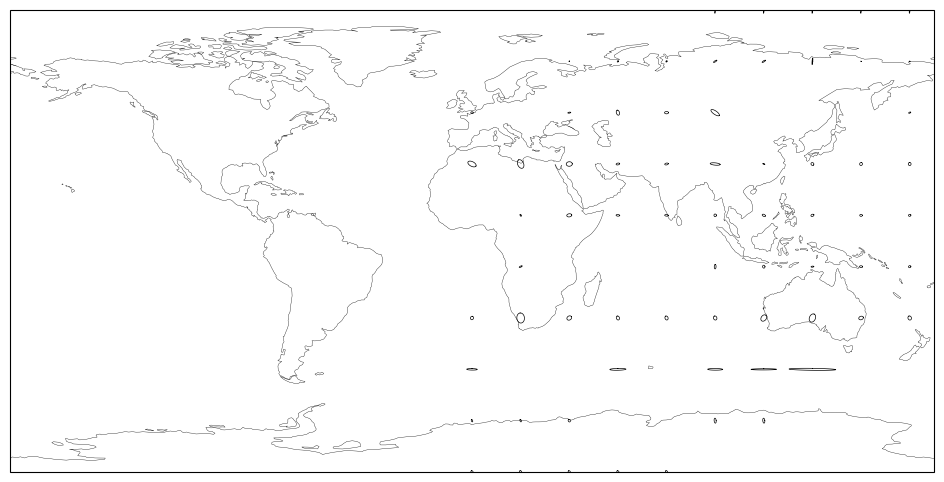

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(linewidth=0.25)
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#ax.gridlines(draw_labels=True)

for lat in target_lats: 
    for lon in target_lons:
        if np.isnan(ds_latlon.sel(lat=lat,lon=lon).uas).all() == False:
            x_ds = ds_latlon.sel(lat=lat,lon=lon).uas.to_numpy() 
            y_ds = ds_latlon.sel(lat=lat,lon=lon).vas.to_numpy()
            points = np.array(list(zip(x_ds[::2] + np.abs(x_ds.min()), y_ds[::2] + np.abs(y_ds.min()))))
            try:
                uelip, velip = smooth_ellipse(points)
                
                #plt.plot(x_ds, y_ds, c='b')
                ax.plot((uelip*2)+lon,(velip*2)+lat, color="k", linewidth=0.5)
            except:
                print(lon, lat)
                continue

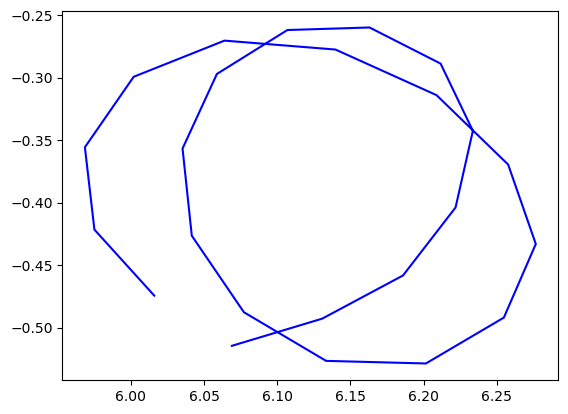

In [93]:
# 341.05263157894734,-50.0
lats = -50.0
lons = 341.05263157894734
x_ds = ds_latlon.sel(lat=lats,lon=lons).uas.to_numpy()
y_ds = ds_latlon.sel(lat=lats,lon=lons).vas.to_numpy()

points = np.array(list(zip(x_ds + np.abs(x_ds.min()), y_ds + np.abs(y_ds.min()))))
#uelip, velip = smooth_ellipse(points)
                
plt.plot(x_ds, y_ds, c='b')
#plt.plot((uelip*2)+lon,(velip*2)+lat, color="k", linewidth=0.5)

### with circle

In [ ]:
def fit_oval(points):
    # extract x-y pairs
    x, y = points.T

    # Quadratic part of design matrix [eqn. 15] from (*)
    D1 = np.vstack([x**2, x*y, y**2]).T
    # Linear part of design matrix [eqn. 16] from (*)
    D2 = np.vstack([x, y, np.ones_like(x)]).T

    # Forming scatter matrix [eqn. 17] from (*)
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2

    # Constraint matrix [eqn. 18]
    C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

    # Reduced scatter matrix [eqn. 29]
    M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

    # M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
    # equation [eqn. 28]
    eigval, eigvec = np.linalg.eig(M)

    # Eigenvector must meet constraint 4ac - b^2 to be valid.
    cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
    a1 = eigvec[:, np.nonzero(cond > 0)[0]]

    if a1.size == 0:
        #print("Ellipse condition not met. Falling back to circle fitting.")

        # Circle fitting: solve (x^2 + y^2 + Dx + Ey + F = 0)
        A = np.column_stack((x, y, np.ones_like(x)))
        b_circle = -(x**2 + y**2)
        circle_coef = np.linalg.lstsq(A, b_circle, rcond=None)[0]
        D, E, F = circle_coef

        x0 = -D / 2
        y0 = -E / 2
        r = np.sqrt((D**2 + E**2) / 4 - F)

        center = (x0, y0)
        width = height = 2 * r /2 # diameter
        phi = 0.0  # circles are not rotated

        #print("Fitted circle with:")
        #print(f"  center = {center}")
        #print(f"  radius = {r}")
        
    else:
        # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
        a2 = la.inv(-S3) @ S2.T @ a1

        # Eigenvectors |a b c d f g>
        # list of the coefficients describing an ellipse [a,b,c,d,e,f]
        # corresponding to ax**2 + bxy + cy**2 + dx + ey + f from (*)
        #self.coef_ = np.vstack([a1, a2])

        """Returns the definition of the fitted ellipse as localized parameters

        Returns
        _______
        center : tuple
            (x0, y0)
        width : float
            Total length (diameter) of horizontal axis.
        height : float
            Total length (diameter) of vertical axis.
        phi : float
            The counterclockwise angle [radians] of rotation from the x-axis to the semimajor axis
        """

        # Eigenvectors are the coefficients of an ellipse in general form
        # the division by 2 is required to account for a slight difference in
        # the equations between (*) and (**)
        # a*x^2 +   b*x*y + c*y^2 +   d*x +   e*y + f = 0  (*)  Eqn 1
        # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0  (**) Eqn 15
        # We'll use (**) to follow their documentation
        if a1.size == 1:
            a = np.vstack([a1,a2])[0]
            b = np.vstack([a1,a2])[1] / 2.
            c = np.vstack([a1,a2])[2]
            d = np.vstack([a1,a2])[3] / 2.
            f = np.vstack([a1,a2])[4] / 2.
            g = np.vstack([a1,a2])[5]
        elif a1.size > 1:
            a = np.vstack([a1,a2])[0].min()
            b = np.vstack([a1,a2])[1].min() / 2.
            c = np.vstack([a1,a2])[2].min()
            d = np.vstack([a1,a2])[3].min() / 2.
            f = np.vstack([a1,a2])[4].min() / 2.
            g = np.vstack([a1,a2])[5].min()
            
        # Finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d - b*f) / (b**2 - a*c)
        y0 = (a*f - b*d) / (b**2 - a*c)
        center = (x0, y0)

        # Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
        denominator1 = (b**2 - a*c) * ( np.sqrt((a-c)**2+4*b**2) - (c+a))  # noqa: E201
        denominator2 = (b**2 - a*c) * (-np.sqrt((a-c)**2+4*b**2) - (c+a))
        height = np.sqrt(numerator / denominator1)
        width = np.sqrt(numerator / denominator2)

        # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
        # [eqn. 23] from (**)
        # w/ trig identity eqn 9 form (***)
        if b == 0 and a > c:
            phi = 0.0
        elif b == 0 and a < c:
            phi = np.pi/2
        elif b != 0 and a > c:
            phi = 0.5 * np.arctan(2*b/(a-c))
        elif b != 0 and a < c:
            phi = 0.5 * (np.pi + np.arctan(2*b/(a-c)))
        elif a == c:
            #print("Ellipse is a perfect circle, the answer is degenerate")
            phi = 0.0
        else:
            raise RuntimeError("Unreachable")
        
    return center, width, height, phi

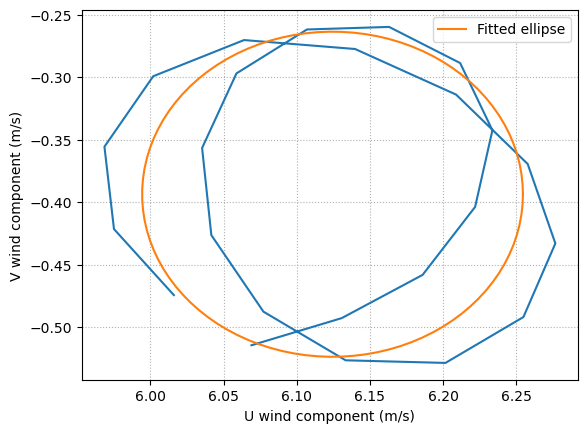

In [128]:
t  = np.linspace(0, 2 * np.pi, 100)
ellipse_u = x0 + width/2 * np.cos(t) * np.cos(phi) - height/2 * np.sin(t) * np.sin(phi)
ellipse_v = y0 + width/2 * np.cos(t) * np.sin(phi) + height/2 * np.sin(t) * np.cos(phi)

plt.plot(x_ds,y_ds)
#plt.plot(u, v, 'o', label='Data points')
plt.plot(ellipse_u, ellipse_v, label='Fitted ellipse')
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("U wind component (m/s)")
plt.ylabel("V wind component (m/s)")
plt.show()

In [153]:
def smooth_oval(points):
    center, width, height, phi = fit_oval(points)
    u0, v0 = (0,0)

    u1 = width * np.cos(phi)
    u2 = -height * np.sin(phi)
    v1 = width * np.sin(phi)
    v2 = height * np.cos(phi)

    t = np.linspace(0, 2 * np.pi, 100)
    uelip = (u0 + u1 * np.cos(t) + u2 * np.sin(t))
    velip = (v0 + v1 * np.cos(t) + v2 * np.sin(t))
    return uelip, velip
    

94.73684210526315 -90.0
113.68421052631578 -90.0
132.6315789473684 -90.0
151.57894736842104 -90.0
170.52631578947367 -90.0
132.6315789473684 -70.0
75.78947368421052 -50.0
170.52631578947367 -50.0
341.05263157894734 -50.0
246.3157894736842 -10.0
341.05263157894734 -10.0
0.0 10.0
360.0 10.0
132.6315789473684 50.0
151.57894736842104 50.0
284.2105263157895 50.0


/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


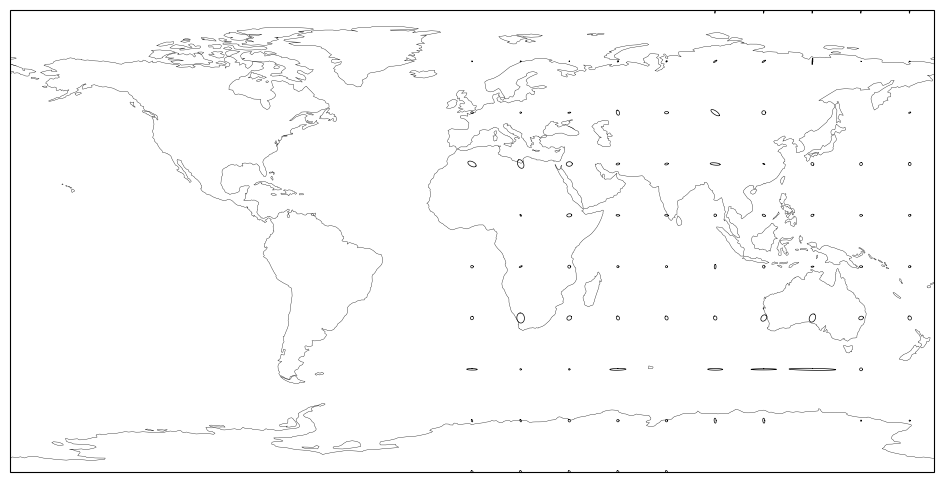

In [154]:
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(linewidth=0.25)
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#ax.gridlines(draw_labels=True)

for lat in target_lats: 
    for lon in target_lons:
        if np.isnan(ds_latlon.sel(lat=lat,lon=lon).uas).all() == False:
            x_ds = ds_latlon.sel(lat=lat,lon=lon).uas.to_numpy() 
            y_ds = ds_latlon.sel(lat=lat,lon=lon).vas.to_numpy()
            points = np.array(list(zip(x_ds[::2] + np.abs(x_ds.min()), y_ds[::2] + np.abs(y_ds.min()))))
            try:
                uelip, velip = smooth_oval(points)
                
                #plt.plot(x_ds, y_ds, c='b')
                ax.plot((uelip*2)+lon,(velip*2)+lat, color="k", linewidth=0.5)
            except:
                print(lon, lat)
                continue
        

In [184]:
# 132.6315789473684 50.0
lat = 50.0
lon = 132.6315789473684

x_ds = ds_latlon.sel(lat=lat,lon=lon).uas.to_numpy() 
y_ds = ds_latlon.sel(lat=lat,lon=lon).vas.to_numpy()
points = np.array(list(zip(x_ds + np.abs(x_ds.mean()), y_ds + np.abs(y_ds.mean()))))

# extract x-y pairs
x, y = points.T

# Quadratic part of design matrix [eqn. 15] from (*)
D1 = np.vstack([x**2, x*y, y**2]).T
# Linear part of design matrix [eqn. 16] from (*)
D2 = np.vstack([x, y, np.ones_like(x)]).T

# Forming scatter matrix [eqn. 17] from (*)
S1 = D1.T @ D1
S2 = D1.T @ D2
S3 = D2.T @ D2

# Constraint matrix [eqn. 18]
C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

# Reduced scatter matrix [eqn. 29]
M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

# M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
# equation [eqn. 28]
eigval, eigvec = np.linalg.eig(M)

# Eigenvector must meet constraint 4ac - b^2 to be valid.
cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
a1 = eigvec[:, np.nonzero(cond > 0)[0]]

if a1.size == 0:
    #print("Ellipse condition not met. Falling back to circle fitting.")

    # Circle fitting: solve (x^2 + y^2 + Dx + Ey + F = 0)
    A = np.column_stack((x, y, np.ones_like(x)))
    b_circle = -(x**2 + y**2)
    circle_coef = np.linalg.lstsq(A, b_circle, rcond=None)[0]
    D, E, F = circle_coef

    x0 = -D / 2
    y0 = -E / 2
    r = np.sqrt((D**2 + E**2) / 4 - F)

    center = (x0, y0)
    width = height = 2 * r /2 # diameter
    phi = 0.0  # circles are not rotated

    #print("Fitted circle with:")
    #print(f"  center = {center}")
    #print(f"  radius = {r}")
    
else:
    # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
    a2 = la.inv(-S3) @ S2.T @ a1

    # Eigenvectors |a b c d f g>
    # list of the coefficients describing an ellipse [a,b,c,d,e,f]
    # corresponding to ax**2 + bxy + cy**2 + dx + ey + f from (*)
    #self.coef_ = np.vstack([a1, a2])

    """Returns the definition of the fitted ellipse as localized parameters

    Returns
    _______
    center : tuple
        (x0, y0)
    width : float
        Total length (diameter) of horizontal axis.
    height : float
        Total length (diameter) of vertical axis.
    phi : float
        The counterclockwise angle [radians] of rotation from the x-axis to the semimajor axis
    """

    # Eigenvectors are the coefficients of an ellipse in general form
    # the division by 2 is required to account for a slight difference in
    # the equations between (*) and (**)
    # a*x^2 +   b*x*y + c*y^2 +   d*x +   e*y + f = 0  (*)  Eqn 1
    # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0  (**) Eqn 15
    # We'll use (**) to follow their documentation
    if a1.size == 1:
        a = np.vstack([a1,a2])[0]
        b = np.vstack([a1,a2])[1] / 2.
        c = np.vstack([a1,a2])[2]
        d = np.vstack([a1,a2])[3] / 2.
        f = np.vstack([a1,a2])[4] / 2.
        g = np.vstack([a1,a2])[5]
    elif a1.size > 1:
        a = np.vstack([a1,a2])[0].mean()
        b = np.vstack([a1,a2])[1].mean() / 2.
        c = np.vstack([a1,a2])[2].mean()
        d = np.vstack([a1,a2])[3].mean() / 2.
        f = np.vstack([a1,a2])[4].mean() / 2.
        g = np.vstack([a1,a2])[5].mean()
        
    # Finding center of ellipse [eqn.19 and 20] from (**)
    x0 = (c*d - b*f) / (b**2 - a*c)
    y0 = (a*f - b*d) / (b**2 - a*c)
    center = (x0, y0)

    # Find the semi-axes lengths [eqn. 21 and 22] from (**)
    numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    denominator1 = (b**2 - a*c) * ( np.sqrt((a-c)**2+4*b**2) - (c+a))  # noqa: E201
    denominator2 = (b**2 - a*c) * (-np.sqrt((a-c)**2+4*b**2) - (c+a))
    height = np.sqrt(numerator / denominator1)
    width = np.sqrt(numerator / denominator2)

    # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
    # [eqn. 23] from (**)
    # w/ trig identity eqn 9 form (***)
    if b == 0 and a > c:
        phi = 0.0
    elif b == 0 and a < c:
        phi = np.pi/2
    elif b != 0 and a > c:
        phi = 0.5 * np.arctan(2*b/(a-c))
    elif b != 0 and a < c:
        phi = 0.5 * (np.pi + np.arctan(2*b/(a-c)))
    elif a == c:
        #print("Ellipse is a perfect circle, the answer is degenerate")
        phi = 0.0
    else:
        raise RuntimeError("Unreachable")
    

def smooth_ellipse(points):
    center, width, height, phi = ellipse_fit(points)
    u0, v0 = (0,0)

    u1 = width * np.cos(phi)
    u2 = -height * np.sin(phi)
    v1 = width * np.sin(phi)
    v2 = height * np.cos(phi)

    t = np.linspace(0, 2 * np.pi, 100)
    uelip = (u0 + u1 * np.cos(t) + u2 * np.sin(t))
    velip = (v0 + v1 * np.cos(t) + v2 * np.sin(t))
    return uelip, velip
    

/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/healpix-cookbook-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


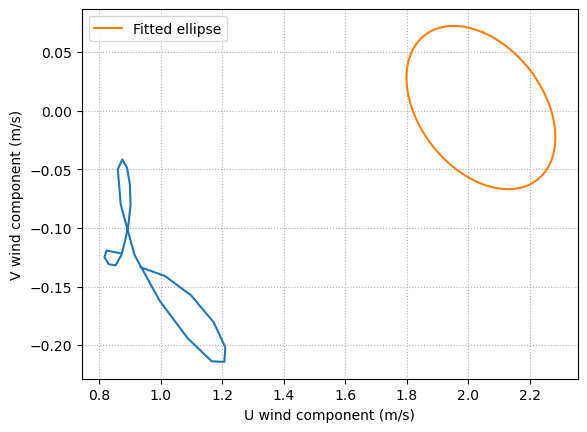

In [185]:
t  = np.linspace(0, 2 * np.pi, 100)
ellipse_u = x0 + width * np.cos(t) * np.cos(phi) - height * np.sin(t) * np.sin(phi)
ellipse_v = y0 + width * np.cos(t) * np.sin(phi) + height * np.sin(t) * np.cos(phi)
u0, v0 = center
u1 = width * np.cos(phi)
u2 = -height * np.sin(phi)
v1 = width * np.sin(phi)
v2 = height * np.cos(phi)
t = np.linspace(0, 2 * np.pi, 100)
ellipse_u  = u0 + u1 * np.cos(t) + u2 * np.sin(t)
ellipse_v = v0 + v1 * np.cos(t) + v2 * np.sin(t)

plt.plot(x_ds,y_ds)
#plt.plot(u, v, 'o', label='Data points')
plt.plot(ellipse_u, ellipse_v, label='Fitted ellipse')
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("U wind component (m/s)")
plt.ylabel("V wind component (m/s)")
plt.show()

In [ ]:
points = np.array(list(zip(x_ds[::2] + np.abs(x_ds.min()), y_ds[::2] + np.abs(y_ds.min()))))

x, y = points.T

# Quadratic part of design matrix
D1 = np.vstack([x**2, x*y, y**2]).T
# Linear part of design matrix
D2 = np.vstack([x, y, np.ones_like(x)]).T

# Scatter matrices
S1 = D1.T @ D1
S2 = D1.T @ D2
S3 = D2.T @ D2

# Constraint matrix
C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

# Reduced scatter matrix
M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

# Solve eigensystem
eigval, eigvec = np.linalg.eig(M)

# Check ellipse condition 4ac - b^2 > 0
cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
a1 = eigvec[:, np.nonzero(cond > 0)[0]]

if a1.size == 0:
    print("Ellipse condition not met. Falling back to circle fitting.")

    # Fit a circle using least squares
    A = np.column_stack((x, y, np.ones_like(x)))
    b_circle = -(x**2 + y**2)
    circle_coef = np.linalg.lstsq(A, b_circle, rcond=None)[0]
    D, E, F = circle_coef

    x0 = -D / 2
    y0 = -E / 2
    r = np.sqrt((D**2 + E**2) / 4 - F)

    center = (x0, y0)
    width = height = 2 * r
    phi = 0.0  # no rotation for circle

    print(f"Fitted circle:")
    print(f"  center = ({x0:.4f}, {y0:.4f})")
    print(f"  radius = {r:.4f}")

else:
    cond = 4*np.multiply(eigvec[0, :], eigvec[2, :]) - np.power(eigvec[1, :], 2)
    a1 = eigvec[:, np.nonzero(cond > 0)[0]]

    a2 = la.inv(-S3) @ S2.T @ a1

    coef = np.concatenate((a1, a2)).ravel()
    a, b, c, d, f, g = coef
    b /= 2.
    d /= 2.
    f /= 2.

    # Ellipse center
    x0 = (c*d - b*f) / (b**2 - a*c)
    y0 = (a*f - b*d) / (b**2 - a*c)
    center = (x0, y0)

    # Axes lengths
    numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    denominator1 = (b**2 - a*c) * (np.sqrt((a - c)**2 + 4*b**2) - (a + c))
    denominator2 = (b**2 - a*c) * (-np.sqrt((a - c)**2 + 4*b**2) - (a + c))
    height = np.sqrt(numerator / denominator1)
    width = np.sqrt(numerator / denominator2)

    # Rotation angle
    if b == 0 and a > c:
        phi = 0.0
    elif b == 0 and a < c:
        phi = np.pi / 2
    elif b != 0 and a > c:
        phi = 0.5 * np.arctan(2 * b / (a - c))
    elif b != 0 and a < c:
        phi = 0.5 * (np.pi + np.arctan(2 * b / (a - c)))
    elif a == c:
        print("Perfect circle; rotation degenerate.")
        phi = 0.0
    else:
        raise RuntimeError("Unreachable ellipse condition.")



# Optional: plot result
theta = np.linspace(0, 2*np.pi, 300)
ellipse = np.array([width/2 * np.cos(theta), height/2 * np.sin(theta)])
R = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
rotated = R @ ellipse
rotated[0, :] += center[0]
rotated[1, :] += center[1]

plt.figure(figsize=(6,6))
plt.plot(x, y, 'ro', label='Data Points')
plt.plot(rotated[0, :], rotated[1, :], 'b-', label='Fitted Ellipse' if valid_idx.size else 'Fitted Circle')
plt.gca().set_aspect('equal')
plt.legend()
plt.title("Ellipse or Circle Fitting")
plt.grid(True)
plt.show()


ValueError: too many values to unpack (expected 6)

In [132]:
#94.73684210526315 -90.0

lon = 94.73684210526315
lat = -90.0

x_ds = ds_latlon.sel(lat=lat,lon=lon).uas.to_numpy() 
y_ds = ds_latlon.sel(lat=lat,lon=lon).vas.to_numpy()
points = np.array(list(zip(x_ds[::2] + np.abs(x_ds.min()), y_ds[::2] + np.abs(y_ds.min()))))

uelip, velip = smooth_oval(points)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

The ellipse is given by 0.478x^2 + -0.6xy+0.398y^2+0.000463x+-0.00889y = 1


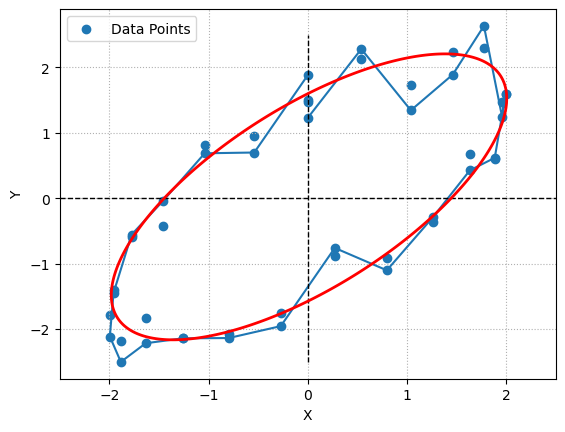

In [141]:
#Generate some random data with 24 hourly samples
h = np.linspace(0, 2 * np.pi, 24)
u = 2*np.sin(h)
v = 2*np.sin(h+np.pi/4)
v = np.random.uniform(v-0.4, v+0.4, 24)
#Plot the data
plt.plot(u,
        np.random.uniform(v-0.4, v+0.4, 24),
        marker='o', linestyle='-', color='tab:blue')
plt.gca().grid(ls=":")
plt.plot([0, 0], [-2.5, 2.5], color='k', lw=1, ls="--")
plt.plot([-2.5, 2.5], [0, 0], color='k', lw=1, ls="--")
plt.ylabel("V wind component (m/s)")
plt.xlabel("U wind component (m/s)")

# Extract x coords and y coords of the ellipse as column vectors
X = u[np.newaxis].T
Y = v[np.newaxis].T

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

# Print the equation of the ellipse in standard form
print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

# Plot the noisy data
plt.scatter(X, Y, label='Data Points')

# Plot the original ellipse from which the data was generated
phi = np.linspace(0, 2*np.pi, 1000).reshape((1000,1))
c = np.hstack([np.cos(phi), np.sin(phi)])
#ground_truth_ellipse = c.dot(B)
#plt.plot(ground_truth_ellipse[:,0], ground_truth_ellipse[:,1], 'k--', label='Generating Ellipse')

# Plot the least squares ellipse
x_coord = np.linspace(-2.5,2.5,300)
y_coord = np.linspace(-2.5,2.5,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [115]:
np.ones_like(X)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [114]:
A

array([36.832798  , 37.58567   , 38.265835  , 38.711143  , 38.858418  ,
       38.58394   , 37.98318   , 37.294533  , 36.70847   , 36.42459   ,
       36.500877  , 36.9323    , 37.61815   , 38.459335  , 39.122955  ,
       39.39639   , 39.15949   , 38.54946   , 37.696793  , 36.771336  ,
       36.0226    , 35.62362   , 35.70138   , 36.191902  , -3.1228738 ,
       -3.021331  , -2.8346348 , -2.51258   , -2.1351128 , -1.7933087 ,
       -1.6011322 , -1.5990199 , -1.7994602 , -2.1526062 , -2.5763476 ,
       -2.963672  , -3.2298353 , -3.2786891 , -3.0771472 , -2.71815   ,
       -2.3121698 , -1.9492512 , -1.7035308 , -1.6391811 , -1.7961168 ,
       -2.1226065 , -2.5188644 , -2.8540401 ,  0.26477328,  0.24287026,
        0.20998248,  0.16308114,  0.11731581,  0.08334961,  0.06749366,
        0.06855869,  0.08821008,  0.12721388,  0.18184678,  0.23782302,
        0.27730855,  0.2795109 ,  0.2420276 ,  0.18753847,  0.13652194,
        0.09856376,  0.07698313,  0.07307091,  0.08955588,  0.12

In [110]:
noisy_ellipse

array([[-3.18153553e+00, -1.22451982e+00],
       [ 1.35543929e+00,  2.16633839e+00],
       [-8.18308415e-01, -2.35330533e+00],
       [-3.12080993e+00, -1.14436980e+00],
       [-2.90902372e+00, -5.10387362e-01],
       [-3.68243761e+00,  6.94018672e-01],
       [-2.21258344e+00,  2.58579365e+00],
       [ 4.37770190e-01, -2.96823373e+00],
       [-3.23797361e+00,  1.52065022e+00],
       [-3.24521784e+00,  1.72686169e+00],
       [ 7.24806951e-01, -2.72380766e+00],
       [-1.51891390e+00, -2.42933248e+00],
       [-1.13582022e+00,  2.60599514e+00],
       [-1.78327827e+00, -2.20933025e+00],
       [-1.72870084e+00,  2.85305522e+00],
       [ 3.16318577e+00, -1.71409040e+00],
       [ 3.29199008e+00, -6.78433739e-01],
       [-2.16889577e+00, -1.98788024e+00],
       [ 3.76107100e+00, -3.46559993e-01],
       [ 1.04185894e-01,  2.50318828e+00],
       [-2.00882171e+00, -2.17360265e+00],
       [ 6.74538712e-01,  2.66853547e+00],
       [-3.17489013e+00, -9.92768384e-01],
       [-9.

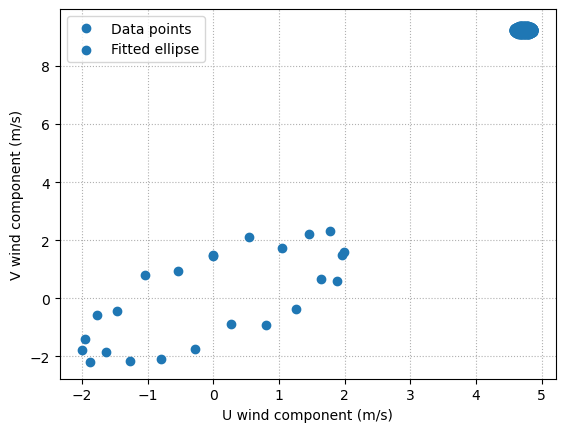

In [180]:
t  = np.linspace(0, 2 * np.pi, 100)
ellipse_u = x0 + width * np.cos(t) * np.cos(phi) - height * np.sin(t) * np.sin(phi)
ellipse_v = y0 + width * np.cos(t) * np.sin(phi) + height * np.sin(t) * np.cos(phi)

plt.plot(u, v, 'o', label='Data points')
plt.scatter(ellipse_u, ellipse_v, label='Fitted ellipse')
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("U wind component (m/s)")
plt.ylabel("V wind component (m/s)")
plt.show()

In [ ]:
b.ny

array([ 0.21633336, -0.42996735, -0.38760036])

In [42]:
b

array([], dtype=float64)

In [33]:
b

array([], dtype=float64)